In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import sys
sys.path.append("../..")

# 中文字体
from matplotlib.font_manager import FontProperties
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=15)

In [2]:
import preprocessing_func as func

In [3]:
DATA_PATH = './0730/data0730/data_seq_ori.tsv'
RESAMPLE_INTERVAL = '6H'
OUTPUT_FILENAME = './0730/data0730/data_rsmp6.tsv'

In [4]:
data = pd.read_csv(DATA_PATH, sep='\t')

In [5]:
data.head()

,hadm_id,stay_id,charttime,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2,...,pt,sodium,bun,wbc,glucose,creatinine,uo_rt_6hr,uo_rt_12hr,uo_rt_24hr,aki_stage
0,20000808,30610654,2180-01-17 20:45:00,58.0,NaN,NaN,NaN,NaN,NaN,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20000808,30610654,2180-01-17 20:48:00,58.0,NaN,NaN,NaN,NaN,37.277778,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20000808,30610654,2180-01-17 20:49:00,NaN,175.0,91.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20000808,30610654,2180-01-17 20:55:00,NaN,NaN,NaN,NaN,11.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20000808,30610654,2180-01-17 21:00:00,57.0,182.0,94.0,127.0,14.0,NaN,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [6]:
data.drop(['hadm_id'], axis=1, inplace=True)

In [7]:
data.shape

(6955511, 32)

In [8]:
data.columns

Index(['stay_id', 'charttime', 'heartrate', 'sysbp', 'diasbp', 'meanbp',
       'resprate', 'tempc', 'spo2', 'aniongap', 'albumin', 'bands',
       'bicarbonate', 'bilirubin', 'chloride', 'hematocrit', 'hemoglobin',
       'lactate', 'platelet', 'potassium', 'ptt', 'inr', 'pt', 'sodium', 'bun',
       'wbc', 'glucose', 'creatinine', 'uo_rt_6hr', 'uo_rt_12hr', 'uo_rt_24hr',
       'aki_stage'],
      dtype='object')

# 异常值处理

In [9]:
# 检查数据中是否有负值, uo(urine output)存在负值是正常的
for i in data.columns:
    if i in ['stay_id', 'charttime']:
        continue
    if len(data[data[i] < 0]):
        print(i)

uo_rt_6hr
uo_rt_12hr
uo_rt_24hr


In [10]:
# 找到df中的id/time/label三列的列名, 以及多余列的列名
id_col, time_col, label_col = 'stay_id', 'charttime', 'aki_stage'
other_cols = []

In [11]:
# 获取异常值处理的上下边界
df_limit = func.get_limit_outliers(data)

In [12]:
df_limit.shape

(31, 2)

In [13]:
df_limit.head()

,lower_limit,upper_limit
stay_id,24906205.5,45020529.5
heartrate,38.0,134.0
sysbp,57.5,181.5
diasbp,24.5,100.5
meanbp,36.5,120.5


In [14]:
# 根据由四分位数计算得到的上下边界处理异常值
for feat in tqdm(data.columns, ncols=100):
    if feat in [id_col, time_col, label_col]:
        continue
    low, up = df_limit.loc[feat]
    data[[feat]] = data[[feat]].mask((data[[feat]] < low) | (data[[feat]] > up))

100%|███████████████████████████████████████████████████████████████| 32/32 [00:03<00:00, 10.03it/s]


In [2]:
# MIMIC样本数: 26582
patients = data[id_col].unique().tolist()
len(patients)

NameError: name 'data' is not defined

In [1]:
import pandas as pd
def custom_aggregate(group):
    non_zero_values = group[group['akistage'] != 0]['akistage']
    if not non_zero_values.empty:
        return non_zero_values.mean()
    else:
        return 0

aggregation_functions = {'aki_stage': 'first', 'akistage': custom_aggregate}
data = data.groupby([id_col, time_col]).agg(aggregation_functions).reset_index()

print(data)

NameError: name 'data' is not defined

In [16]:
# 聚合同一时间点的记录
data[time_col] = pd.to_datetime(data[time_col])
data.sort_values(by=[id_col, time_col], ascending=True, inplace=True)
data = data.groupby([id_col, time_col]).mean()
data.reset_index(drop=False, inplace=True)
data.dropna(subset=data.columns[2:], how='all', inplace=True)
data.reset_index(drop=True, inplace=True)

# 住院时长统计

In [17]:
admission_los = func.get_len_of_stay(data=data, id_col=id_col, time_col=time_col, batch_size=1000)

100%|███████████████████████████████████████████████████████████████| 29/29 [00:26<00:00,  1.08it/s]


In [18]:
los_max = max(admission_los.values())
los_min =  min(admission_los.values())
# MIMIC病人住院时长第95百分位数: 20.81天
los_95th = np.percentile(list(admission_los.values()), 95)
# 数据记录最低时长: 2天
low_limit = 2
los_min, los_max, los_95th

(0.5, 101.58, 17.12)

In [19]:
# 统计住院时数据记录总时长不在2~20.81天内的人数
count = 0
for k, v in admission_los.items():
    if v <= low_limit or v > los_95th:
        count += 1
count, len(patients)-count

(2797, 25861)

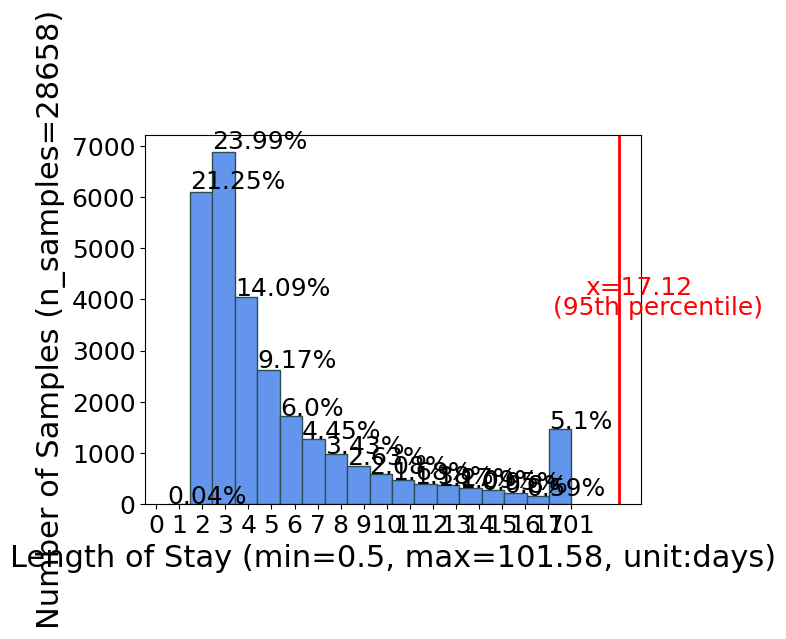

In [20]:
# hist_up_limt: 柱状图x轴顶点
# 将大于los_95th的值替换为hist_up_limit, 方便绘图
hist_up_limit = math.ceil(los_95th)
hist_values = [i if i <= los_95th else hist_up_limit for i in admission_los.values()]
# X轴刻度
xticks = [int(i) for i in list(np.linspace(0, hist_up_limit-1, hist_up_limit))]
xticks.append(int(los_max))
# 绘制住院时长分布图
fig = plt.hist(hist_values, bins=hist_up_limit, edgecolor='darkslategrey', color='cornflowerblue')
plt.ylabel('Number of Samples (n_samples={0})'.format(len(admission_los)), fontsize=22)
plt.xlabel('Length of Stay (min={0}, max={1}, unit:days)'.format(los_min, los_max), fontsize=22)
# 将X轴原刻度替换为前面设置的xticks
plt.xticks(np.linspace(0, hist_up_limit, hist_up_limit+1), xticks, fontsize=18)
plt.yticks(fontsize=18)
# 绘制los_95th在图中的位置
plt.axvline(x=20.04, color='r', linewidth=2.0)
plt.rcParams['figure.figsize'] = (23, 8)
# 添加标注性文字
for p, b in zip(fig[0], fig[1]):
    plt.text(b, 1.01*p, str(round(p/len(admission_los)*100, 2))+"%", fontsize=18)
plt.text(18.6, 4100, f'x={los_95th}', color='r', fontsize=18)    # fix
plt.text(17.2, 3700, f'(95th percentile)', color='r', fontsize=18)    # fix

plt.savefig('./plot0726/MIMIC病人住院时长分布图.png', dpi=800, bbox_inches='tight', pad_inches=0.0)
plt.show()

In [21]:
# 保留实际ICU入住时长在2~20.81天内的病人ID
keep_id = []
for k, v in admission_los.items():
    if low_limit < v <= los_95th:
        keep_id.append(k)
len(keep_id)
# MIMIC病人: 23702

25861

In [22]:
data = data[data[id_col].isin(keep_id)].copy()
data.reset_index(drop=True, inplace=True)
data.shape
# (4756049, 32)

(5280996, 32)

# 特征覆盖度和信息完整度统计

In [23]:
feature_coverage_ratio, infor_integrity_ratio = func.get_cov_infor_ratio(
    data=data, 
    id_col=id_col, 
    time_col=time_col, 
    label_col=label_col, 
    non_feat_col_num=3
)

100%|█████████████████████████████████████████████████████████████████| 3/3 [01:10<00:00, 23.51s/it]

patients num: 25861, features num: 29


In [24]:
# 保存数据
cov = pd.DataFrame(columns=['features', 'origin'])
info = pd.DataFrame(columns=['patient_id', 'origin'])
cov.features = list(feature_coverage_ratio.keys())
cov.origin = list(feature_coverage_ratio.values())
info.patient_id = list(infor_integrity_ratio.keys())
info.origin = list(infor_integrity_ratio.values())

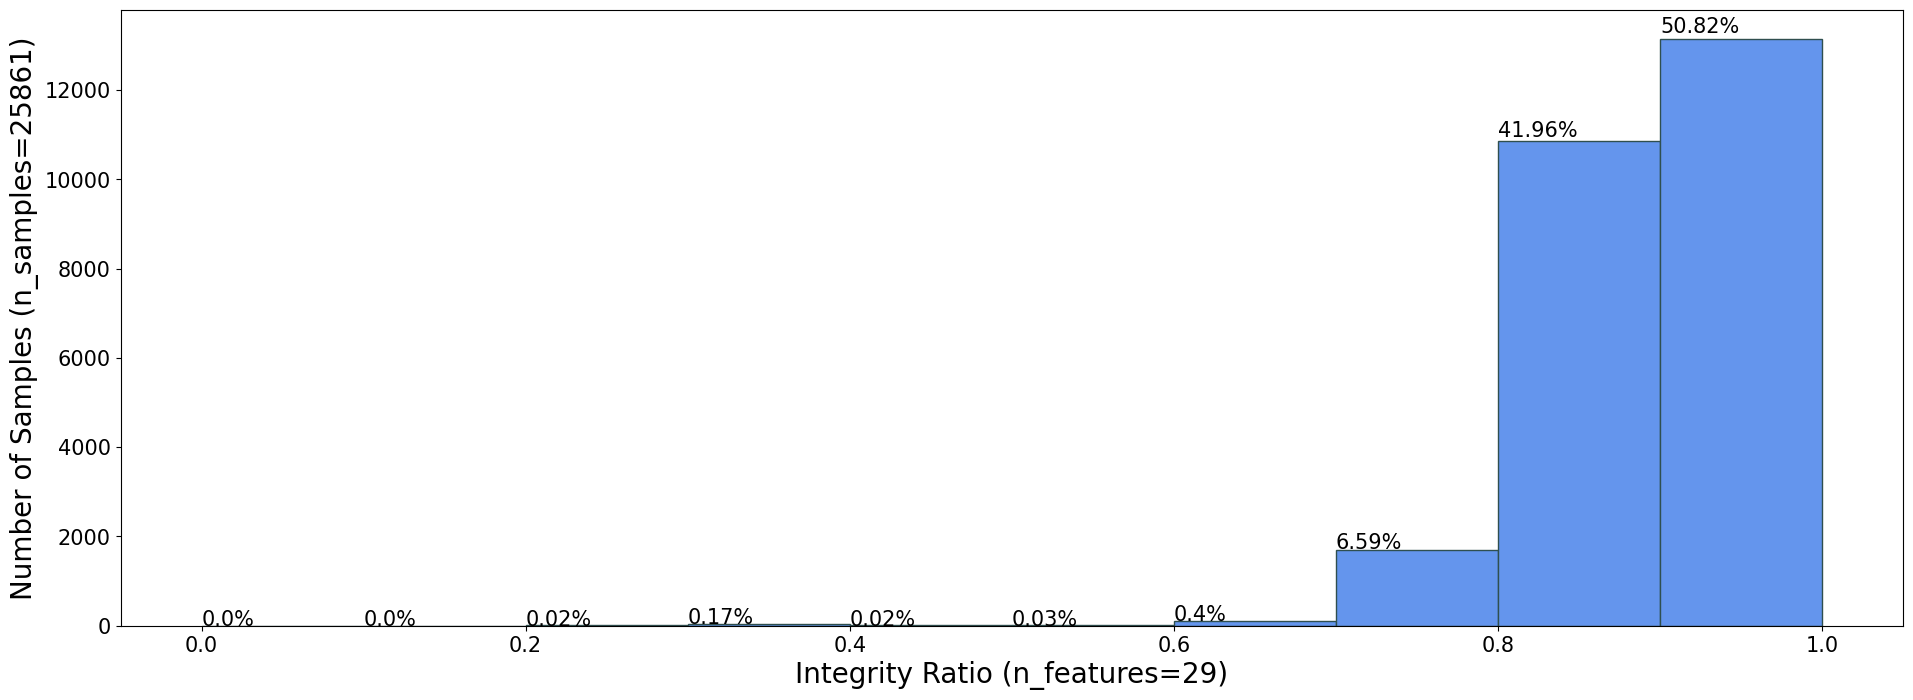

In [25]:
# 绘图
func.plot_infor_integrity(
    values=info.origin.values, 
    sample_num=len(infor_integrity_ratio), 
    feature_num=len(feature_coverage_ratio), 
    is_save=False, save_dir='./0730/plot0730/MIMIC信息完整度.png')

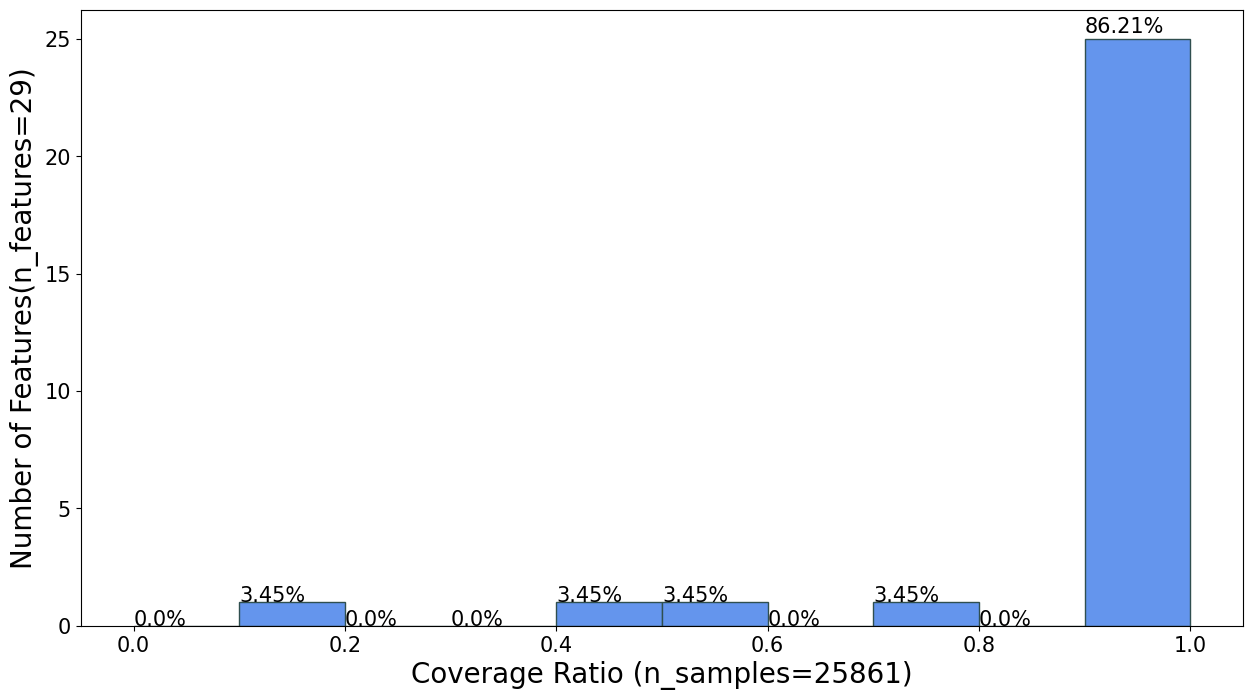

In [26]:
func.plot_feature_coverage(
    values=cov.origin.values, 
    sample_num=len(infor_integrity_ratio), 
    feature_num=len(feature_coverage_ratio), 
    is_save=False, save_dir='./0730/plot0730/MIMIC特征覆盖度.png')

In [27]:
# 保留特征覆盖度大于0.8的特征
keep_feat = []
for k, v in feature_coverage_ratio.items():
    if v >= 0.8:
        keep_feat.append(k)
    else:
        print(k)
keep_feat = [id_col, time_col, label_col] + keep_feat

albumin
bands
bilirubin
lactate


In [28]:
data = data[keep_feat].copy()

In [29]:
# 重新统计信息覆盖度
feature_coverage_ratio, infor_integrity_ratio = func.get_cov_infor_ratio(
    data=data, 
    id_col=id_col, 
    time_col=time_col, 
    label_col=label_col, 
    non_feat_col_num=3
)

100%|█████████████████████████████████████████████████████████████████| 3/3 [01:10<00:00, 23.40s/it]

patients num: 25861, features num: 25


In [30]:
# 保存数据
cov_after = pd.DataFrame(columns=['features', 'after'])
info_after = pd.DataFrame(columns=['patient_id', 'after'])
cov_after.features = list(feature_coverage_ratio.keys())
cov_after.after = list(feature_coverage_ratio.values())
info_after.patient_id = list(infor_integrity_ratio.keys())
info_after.after = list(infor_integrity_ratio.values())
cov = pd.merge(left=cov, right=cov_after, how='outer', on='features')
info = pd.merge(left=info, right=info_after, how='outer', on='patient_id')

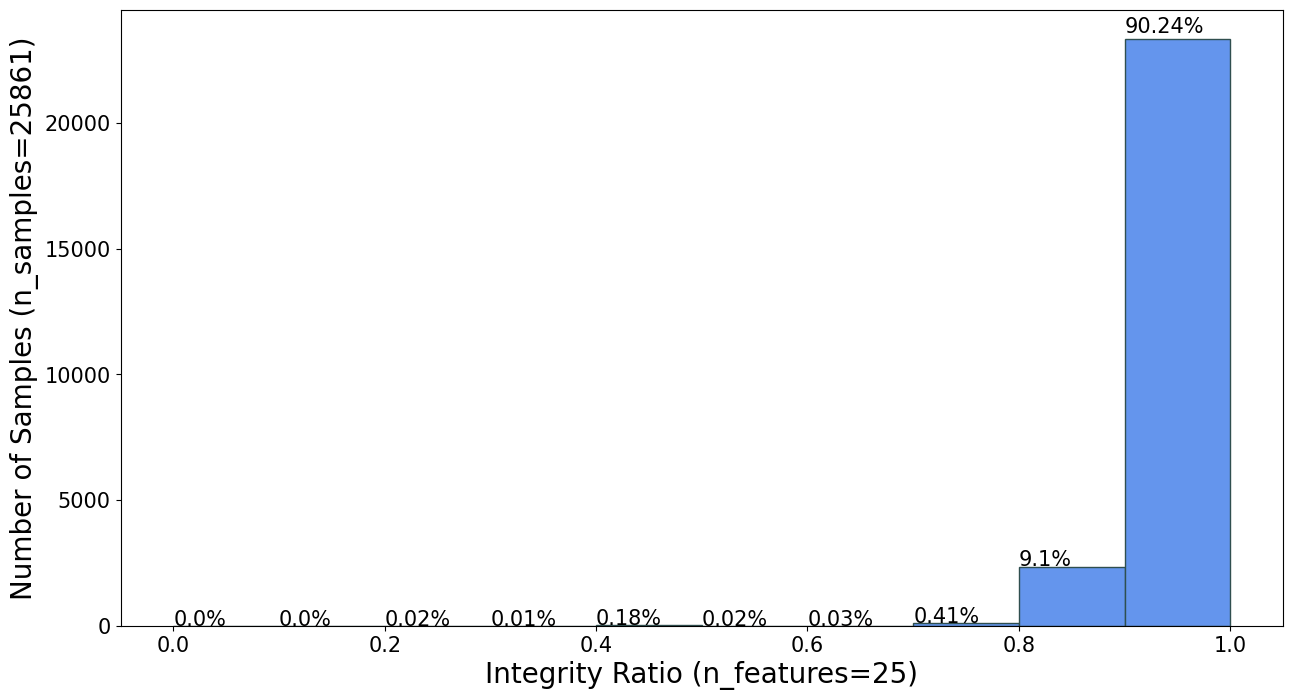

In [31]:
func.plot_infor_integrity(
    values=info.after.values, 
    sample_num=len(infor_integrity_ratio), 
    feature_num=len(feature_coverage_ratio), 
    is_save=False, save_dir='./0730//plot0730/MIMIC信息完整度_after.png')

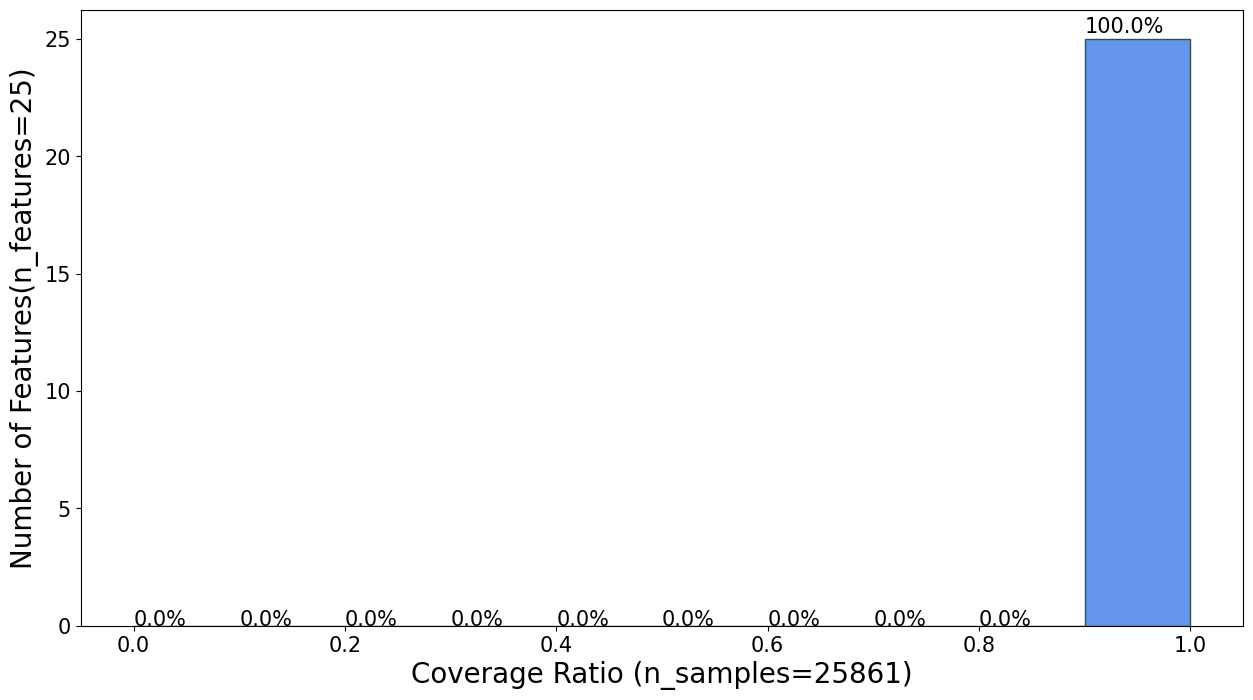

In [32]:
func.plot_feature_coverage(
    values=cov.after.values, 
    sample_num=len(infor_integrity_ratio), 
    feature_num=len(feature_coverage_ratio), 
    is_save=False, save_dir='./0730/plot0730/MIMIC特征覆盖度_after.png')

In [34]:
# 保存数据
cov.to_excel('./0730//plot0730/MIMIC特征覆盖度.xls', index=False)
info.to_excel('./0730/plot0730/MIMIC信息完整度.xls', index=False)

In [35]:
# 保留信息完整度不小于0.8的样本
keep_id = []
for k, v in infor_integrity_ratio.items():
    if v >= 0.8:
        keep_id.append(k)
len(keep_id)
# MIMIC: 23325

25691

In [36]:
data = data[data[id_col].isin(keep_id)].copy()

In [37]:
data.shape

(5257143, 28)

In [38]:
data.columns

Index(['stay_id', 'charttime', 'aki_stage', 'heartrate', 'sysbp', 'diasbp',
       'meanbp', 'resprate', 'tempc', 'spo2', 'aniongap', 'bicarbonate',
       'chloride', 'hematocrit', 'hemoglobin', 'platelet', 'potassium', 'ptt',
       'inr', 'pt', 'sodium', 'bun', 'wbc', 'glucose', 'creatinine',
       'uo_rt_6hr', 'uo_rt_12hr', 'uo_rt_24hr'],
      dtype='object')

# resample

In [39]:
features = data.columns.tolist()[2:]
len(features)

26

In [40]:
features

['aki_stage',
 'heartrate',
 'sysbp',
 'diasbp',
 'meanbp',
 'resprate',
 'tempc',
 'spo2',
 'aniongap',
 'bicarbonate',
 'chloride',
 'hematocrit',
 'hemoglobin',
 'platelet',
 'potassium',
 'ptt',
 'inr',
 'pt',
 'sodium',
 'bun',
 'wbc',
 'glucose',
 'creatinine',
 'uo_rt_6hr',
 'uo_rt_12hr',
 'uo_rt_24hr']

In [41]:
features.remove('aki_stage')
label = ['aki_stage']

In [42]:
# 检查时间列数据类型
data[[time_col]].dtypes

charttime    datetime64[ns]
dtype: object

In [43]:
data_resample = func.get_resample(
    data=data, 
    id_col=id_col, 
    time_col=time_col, 
    time_gap=RESAMPLE_INTERVAL, 
    numeric_features=features, 
    discrete_features=label
)

100%|█████████████████████████████████████████████████████████████████| 3/3 [01:25<00:00, 28.65s/it]

patient num: 25691


In [44]:
data_resample.shape

(532330, 28)

In [45]:
data_resample.columns

Index(['stay_id', 'charttime', 'heartrate', 'sysbp', 'diasbp', 'meanbp',
       'resprate', 'tempc', 'spo2', 'aniongap', 'bicarbonate', 'chloride',
       'hematocrit', 'hemoglobin', 'platelet', 'potassium', 'ptt', 'inr', 'pt',
       'sodium', 'bun', 'wbc', 'glucose', 'creatinine', 'uo_rt_6hr',
       'uo_rt_12hr', 'uo_rt_24hr', 'aki_stage'],
      dtype='object')

In [46]:
data_resample.to_csv(OUTPUT_FILENAME, sep='\t', index=False)